In [1]:
# Import

import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay, roc_curve

pd.set_option("display.max_columns", None)

In [2]:
# Cleaning

df = pd.read_csv("../data/data.csv", sep=",")
df = df.dropna()
df = df.drop_duplicates(subset=['customerID'], keep="last")
df = df[df["TotalCharges"] != " "]

Q1 = df["MonthlyCharges"].quantile(q=0.25)
Q3 = df["MonthlyCharges"].quantile(q=0.75)
QR = Q3 - Q1
df = df[(df["MonthlyCharges"] >= Q1 - 1.5*QR) & (df["MonthlyCharges"] <= Q3 + 1.5*QR)]

df["TotalCharges"] = df["TotalCharges"].astype("float64")
Q1 = df["TotalCharges"].quantile(q=0.25)
Q3 = df["TotalCharges"].quantile(q=0.75)
QR = Q3 - Q1
df = df[(df["TotalCharges"] >= Q1 - 1.5*QR) & (df["TotalCharges"] <= Q3 + 1.5*QR)]
df = df.drop(columns=['customerID'])

In [4]:
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df = pd.get_dummies(df, 
columns=['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
         'TechSupport',	'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
        ], drop_first=False, dtype = int)

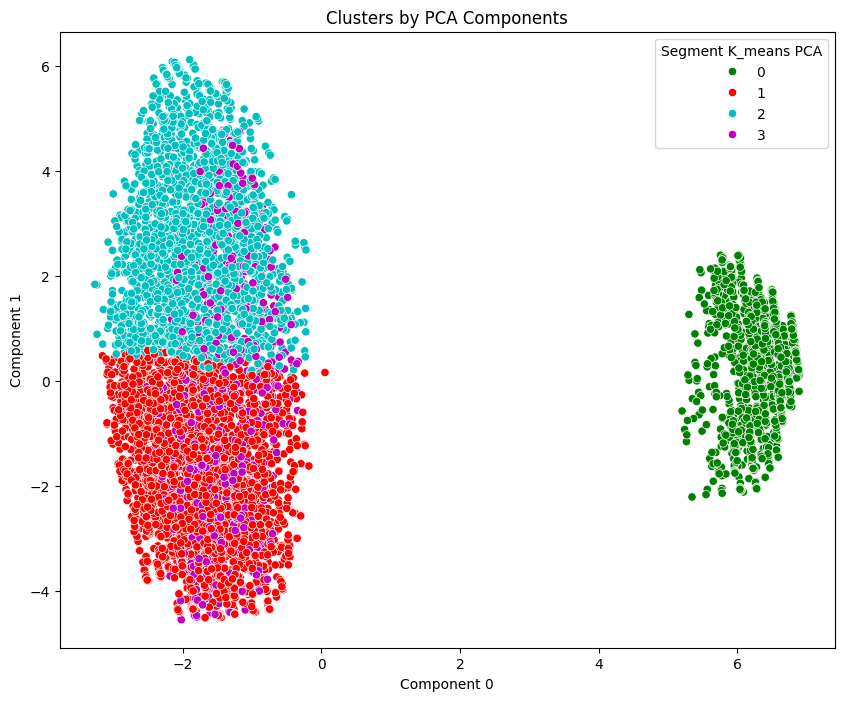

0.3055523402824882

In [20]:
# Normalize

scaler = StandardScaler()
standardized_df = scaler.fit_transform(df)

# pca = PCA()
# pca.fit(standardized_df)

# plt.figure(figsize=(10,8))
# plt.plot(range(42), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
# plt.ylabel('Cumuluative Explained Variance')
# plt.xlabel('Number of Components')
# plt.title('Explained Variance by Components')

# Feature Reduction
pca = PCA(n_components=10)
pca.fit(standardized_df)
scores_pca = pca.transform(standardized_df)

# Determine number of clusters
# wcss = []
# for i in range(1, 21):
#     kmeans_pca =  KMeans(n_clusters=i, random_state=42)
#     kmeans_pca.fit(scores_pca)
#     wcss.append(kmeans_pca.inertia_)

# plot
# plt.figure(figsize=(10,8))
# plt.plot(range(1,21), wcss, marker = 'o', linestyle = '--')
# plt.ylabel('WCSS')
# plt.title('Kmeans with PCA Clustering')
#plt.show()

# Model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(scores_pca)

# Analysis
df_segm_pca_kmeans = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-10:] = [f'Component {i}' for i in range(10)]
df_segm_pca_kmeans['Segment K_means PCA'] = kmeans.labels_

#Plot
#2 most important composants for axes
x_axis = df_segm_pca_kmeans['Component 0']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Segment K_means PCA'], palette = ['g', 'r', 'c', 'm'])
plt.title("Clusters by PCA Components")
plt.show()

#Silhouette Score
sil_score = silhouette_score(scores_pca, kmeans.labels_)
sil_score

In [6]:
cluster_means = df_segm_pca_kmeans.drop(columns=[f'Component {i}' for i in range(10)]).groupby('Segment K_means PCA').mean()

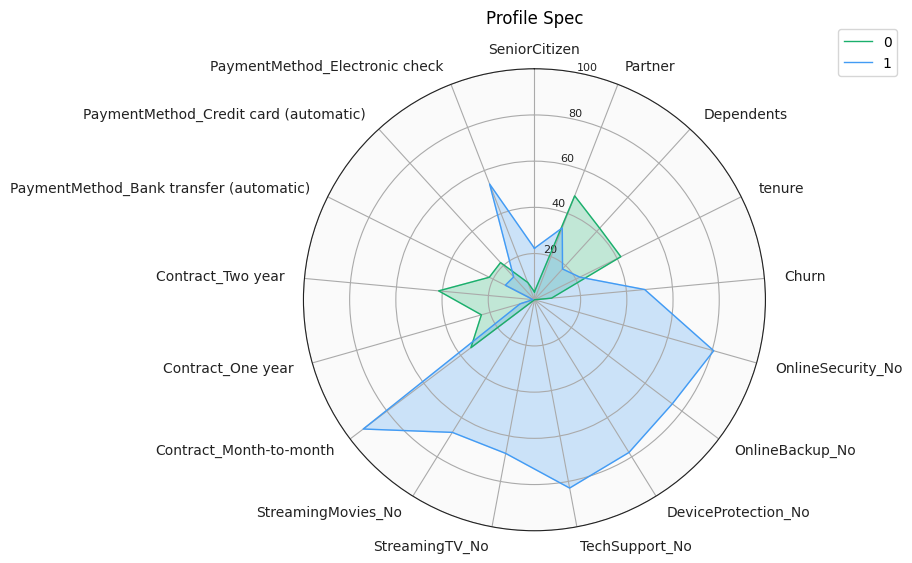

In [22]:
factors = cluster_means.corr()["Churn"][(abs(cluster_means.corr()["Churn"]) >= 0.7)].index

# New scale should be from 0 to 100.
new_max = 100
new_min = 0
new_range = new_max - new_min

dft = pd.DataFrame()

# Do a linear transformation on each variable to change value
# to [0, 100].
for factor in factors:
  max_val = df[factor].max()
  min_val = df[factor].min()
  val_range = max_val - min_val
  dft[factor] = cluster_means[factor].apply(
      lambda x: (((x - min_val) * new_range) / val_range) + new_min)

labels = dft.columns

num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
#ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Helper function to plot each car on the radar chart.
def add_to_radar(profile_index, color):
  values = dft.loc[profile_index, labels].tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=1, label=profile_index)
  ax.fill(angles, values, color=color, alpha=0.25)

add_to_radar(0, '#1aaf6c')
add_to_radar(1, '#429bf4')
# add_to_radar(2, '#d42cea')
# add_to_radar(3, '#e85cff')

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Go through labels and adjust alignment based on where
# it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(0, 100)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')

# Lastly, give the chart a title and give it some
# padding above the "Acceleration" label.
ax.set_title('Profile Spec', y=1.08)

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

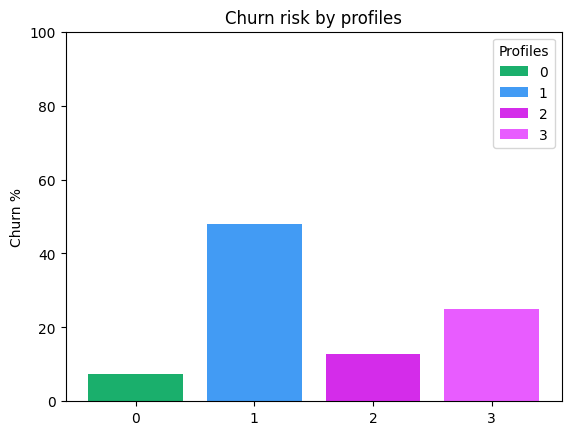

In [8]:
# Data for plotting
fig, ax = plt.subplots()
labels = cluster_means.index.to_numpy()
values = cluster_means["Churn"].to_numpy() * 100
bar_colors = ['#1aaf6c', '#429bf4', '#d42cea', '#e85cff']

# Create bar plot
ax.bar(labels, values, label=labels, color=bar_colors)

# Add labels and title
ax.set_ylabel("Churn %")
ax.set_title("Churn risk by profiles")
ax.legend(title='Profiles')
ax.set_ylim(0, 100)
plt.xticks(np.arange(min(labels), max(labels)+1, 1.0))

# Show plot
plt.show()

In [9]:
# Churn Prediction
# Logistic Regression

y = df_segm_pca_kmeans["Churn"]
X = df_segm_pca_kmeans.drop(columns=[f'Component {i}' for i in range(10)]).drop(columns=["Churn"])
X = pd.get_dummies(X, columns=['Segment K_means PCA'], drop_first=True, dtype = int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_normalized = (X_train - X_train_mean) / X_train_std
X_test_normalized = (X_test - X_train_mean) / X_train_std

model = LogisticRegression(class_weight='balanced')
clf = model.fit(X_train_normalized, y_train)

#y_pred = clf.predict(X_test_normalized)

# Lower the threashold
y_proba = clf.predict_proba(X_test_normalized)[:,1]
y_pred = (y_proba > 0.3).astype(int)  # seuil 0.3

In [10]:
print("Quality Metrics of Logistic Regression Model : \n")

log_reg_accuracy = accuracy_score(y_test, y_pred)
print(f"- Accuracy of Logistic Regression = {log_reg_accuracy:.2f}")

y_proba = model.predict_proba(X_test_normalized)[:, 1]
log_reg_auc = roc_auc_score(y_test, y_proba)
print(f"- AUC of Logistic Regression = {log_reg_auc:.2f}")

log_reg_confusion_matrix = confusion_matrix(y_test, y_pred)
print(f"- Confusion matrix of Logistic Regression = \n{log_reg_confusion_matrix}")

log_reg_f1_score = f1_score(y_test, y_pred, average=None)
print(f"- F1 Score of Logistic Regression = {log_reg_f1_score}")

log_reg_cross_validation = np.mean(cross_val_score(clf, X_train_normalized, y_train, cv=5))
print(f"- Crossvalidation of Logistic Regression = {log_reg_cross_validation:.2f}")

Quality Metrics of Logistic Regression Model : 

- Accuracy of Logistic Regression = 0.73
- AUC of Logistic Regression = 0.83
- Confusion matrix of Logistic Regression = 
[[719 314]
 [ 66 308]]
- F1 Score of Logistic Regression = [0.7909791 0.6184739]
- Crossvalidation of Logistic Regression = 0.84


In [11]:
# Gradient Boosting
# param_grid_gb = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7]
# }

# grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=0),
#                        param_grid_gb, cv=5, scoring='f1')
# grid_gb.fit(X_train_normalized, y_train)
# print("Best params GB:", grid_gb.best_params_)
# print("Best F1 score GB:", grid_gb.best_score_)

# Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 5],
#     'max_features': ['sqrt'],
#     'class_weight': ['balanced']
# }

# grid_rf = GridSearchCV(RandomForestClassifier(random_state=0),
#                        param_grid_rf, cv=5, scoring='f1')
# grid_rf.fit(X_train_normalized, y_train)
# print("Best params RF:", grid_rf.best_params_)
# print("Best F1 score RF:", grid_rf.best_score_)


In [12]:
# Random Forest

# Model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced',
    max_features='sqrt'
)
clf = model.fit(X_train_normalized, y_train)
y_proba = clf.predict_proba(X_test_normalized)[:,1]
y_pred = (y_proba > 0.3).astype(int)  # seuil 0.3

In [13]:
print("Quality Metrics of Random Forest Model : \n")

ran_forest_accuracy = accuracy_score(y_test, y_pred)
print(f"- Accuracy of Random Forest = {ran_forest_accuracy:.2f}")

y_proba = model.predict_proba(X_test_normalized)[:, 1]
ran_forest_auc = roc_auc_score(y_test, y_proba)
print(f"- AUC of Random Forest = {ran_forest_auc:.2f}")

ran_forest_confusion_matrix = confusion_matrix(y_test, y_pred)
print(f"- Confusion matrix of Random Forest = \n{ran_forest_confusion_matrix}")

ran_forest_f1_score = f1_score(y_test, y_pred, average=None)
print(f"- F1 Score of Random Forest = {ran_forest_f1_score}")

ran_forest_cross_validation = np.mean(cross_val_score(clf, X_train_normalized, y_train, cv=5))
print(f"- Crossvalidation of Random Forest = {ran_forest_cross_validation:.2f}")

Quality Metrics of Random Forest Model : 

- Accuracy of Random Forest = 0.73
- AUC of Random Forest = 0.81
- Confusion matrix of Random Forest = 
[[740 293]
 [ 88 286]]
- F1 Score of Random Forest = [0.79527136 0.60020986]
- Crossvalidation of Random Forest = 0.85


In [14]:
# Gradient Boost

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,
    max_depth=3, random_state=0)

clf = model.fit(X_train_normalized, y_train)

y_proba = clf.predict_proba(X_test_normalized)[:,1]
y_pred = (y_proba > 0.3).astype(int)  # seuil 0.3

In [15]:
print("Quality Metrics of Gradient Boost : \n")

grad_boost_accuracy = accuracy_score(y_test, y_pred)
print(f"- Accuracy of Gradient Boost = {grad_boost_accuracy:.2f}")

y_proba = model.predict_proba(X_test_normalized)[:, 1]
grad_boost_auc = roc_auc_score(y_test, y_proba)
print(f"- AUC of Gradient Boost = {grad_boost_auc:.2f}")

grad_boost_confusion_matrix = confusion_matrix(y_test, y_pred)
print(f"- Confusion matrix of Gradient Boost = \n{grad_boost_confusion_matrix}")

grad_boost_f1_score = f1_score(y_test, y_pred, average=None)
print(f"- F1 Score of Gradient Boost = {grad_boost_f1_score}")

grad_boost_cross_validation = np.mean(cross_val_score(clf, X_train_normalized, y_train, cv=5))
print(f"- Crossvalidation of Gradient Boost = {grad_boost_cross_validation:.2f}")

Quality Metrics of Gradient Boost : 

- Accuracy of Gradient Boost = 0.71
- AUC of Gradient Boost = 0.83
- Confusion matrix of Gradient Boost = 
[[702 331]
 [ 70 304]]
- F1 Score of Gradient Boost = [0.77783934 0.60257681]
- Crossvalidation of Gradient Boost = 0.84


In [16]:

# 1️⃣ Définir les modèles de base (base learners)
base_learners = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=None,
                                  random_state=42, class_weight='balanced',
                                  max_features='sqrt')),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,
                                      max_depth=3, random_state=0))
]

# 2️⃣ Définir le meta-learner
meta_learner = LogisticRegression()

# 3️⃣ Créer le StackingClassifier
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,  # cross-validation pour générer les prédictions des modèles de base
    passthrough=False  # si True, ajoute aussi les features originales
)

# 4️⃣ Entraîner le modèle
stack_model.fit(X_train_normalized, y_train)

# 5️⃣ Prédictions
#y_pred = stack_model.predict(X_test_normalized)
y_proba = stack_model.predict_proba(X_test_normalized)[:, 1]
y_pred = (y_proba > 0.3).astype(int)  # seuil 0.3

# 6️⃣ Metrics
print("Stacking Model Metrics:\n")
print(f"- Accuracy = {accuracy_score(y_test, y_pred):.2f}")
print(f"- AUC = {roc_auc_score(y_test, y_proba):.2f}")
print(f"- Confusion Matrix = \n{confusion_matrix(y_test, y_pred)}")
print(f"- F1 Score = {f1_score(y_test, y_pred, average=None)}")


Stacking Model Metrics:

- Accuracy = 0.75
- AUC = 0.83
- Confusion Matrix = 
[[770 263]
 [ 94 280]]
- F1 Score = [0.81180812 0.61068702]


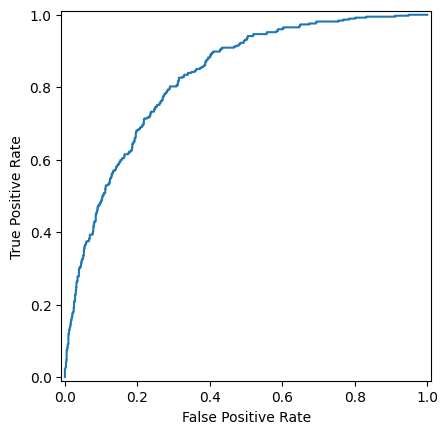

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=stack_model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()